In [17]:
import os
import time
import torch
import timm
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import datasets, transforms, models as torchvision_models
from torch.utils.data import DataLoader
from torch import optim, nn
from tqdm import tqdm
# Load feature extractor and model
model = timm.create_model('efficientnet_lite0', pretrained=True)
num_features = model.classifier.in_features
model.classifier = torch.nn.Linear(num_features, 10)

In [27]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_loader = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)
train_loader = DataLoader(fashion_mnist_train, batch_size=64, shuffle=True, num_workers=1)



In [21]:
print(len(train_loader))  
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break  

235
torch.Size([256, 3, 28, 28]) torch.Size([256])


In [28]:


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
device = torch.device("mps")
model.to(device)
training_loss = []
training_accuracy = []

model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    batch_count = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        

        outputs = model(images)
        loss = criterion(outputs, labels)  
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        batch_count += 1

        progress_bar.set_postfix({
            'Loss': f'{total_loss / batch_count:.4f}',
            'Accuracy': f'{(correct_predictions / total_predictions * 100):.2f}%'
        })
    
    epoch_loss = total_loss / batch_count
    epoch_accuracy = correct_predictions / total_predictions * 100
    training_loss.insert(epoch, epoch_loss)
    training_accuracy.insert(epoch, epoch_accuracy)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Epoch 1: 100%|██████████| 938/938 [00:55<00:00, 16.83it/s, Loss=0.3757, Accuracy=87.01%]


Epoch 1, Loss: 0.3757, Accuracy: 87.01%


Epoch 2: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s, Loss=0.3227, Accuracy=88.87%]


Epoch 2, Loss: 0.3227, Accuracy: 88.87%


Epoch 3: 100%|██████████| 938/938 [00:53<00:00, 17.69it/s, Loss=0.2853, Accuracy=89.90%]


Epoch 3, Loss: 0.2853, Accuracy: 89.90%


Epoch 4: 100%|██████████| 938/938 [00:52<00:00, 17.88it/s, Loss=0.2624, Accuracy=90.78%]


Epoch 4, Loss: 0.2624, Accuracy: 90.78%


Epoch 5: 100%|██████████| 938/938 [00:52<00:00, 17.87it/s, Loss=0.2468, Accuracy=91.26%]


Epoch 5, Loss: 0.2468, Accuracy: 91.26%


Epoch 6: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s, Loss=0.2310, Accuracy=91.66%]


Epoch 6, Loss: 0.2310, Accuracy: 91.66%


Epoch 7: 100%|██████████| 938/938 [00:53<00:00, 17.57it/s, Loss=0.2171, Accuracy=92.27%]


Epoch 7, Loss: 0.2171, Accuracy: 92.27%


Epoch 8: 100%|██████████| 938/938 [00:53<00:00, 17.70it/s, Loss=0.2046, Accuracy=92.62%]


Epoch 8, Loss: 0.2046, Accuracy: 92.62%


Epoch 9: 100%|██████████| 938/938 [00:57<00:00, 16.28it/s, Loss=0.1962, Accuracy=92.98%]


Epoch 9, Loss: 0.1962, Accuracy: 92.98%


Epoch 10: 100%|██████████| 938/938 [00:58<00:00, 16.04it/s, Loss=0.1897, Accuracy=93.16%]

Epoch 10, Loss: 0.1897, Accuracy: 93.16%


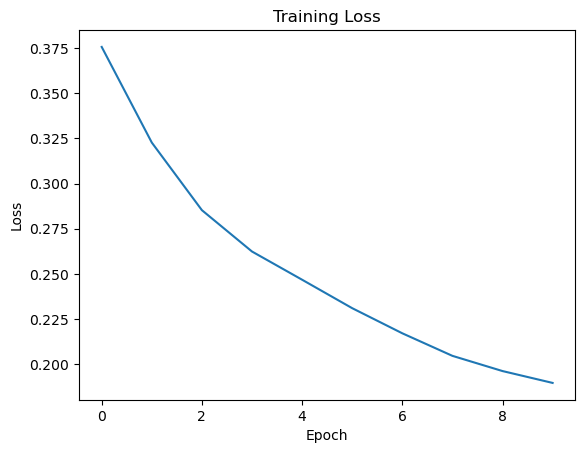

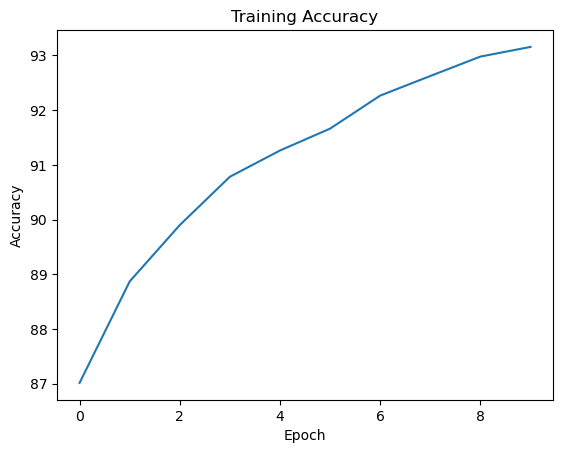

In [29]:
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.plot(training_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [30]:
def evaluate_accuracy(ddm, data_loader, device='mps'):

    ddm.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating Accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = ddm(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')



original_accuracy = evaluate_accuracy(model, test_loader, device)
print(f'Original Model Accuracy: {original_accuracy:.2f}%')


torchscript = torch.jit.script(model)
torchscript_accuracy = evaluate_accuracy(torchscript, test_loader, device)
print(f'TorchScript Model Accuracy: {torchscript_accuracy:.2f}%')




Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 52.60it/s]


Original Model Accuracy: 91.46%


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.20it/s]

TorchScript Model Accuracy: 91.46%


In [32]:

def benchmark_model(model, input, iterations=100, device='mps'):
    start = time.time()
    model.to(device)
    model.eval()
    input = input.to(device)
    with torch.no_grad():
        for _ in tqdm(range(iterations), desc="Benchmarking Model"):
            output = model(input)
    end = time.time()
    return iterations/(end-start)



original_time = benchmark_model(model, next(iter(test_loader))[0], device=device)
print(f'Original Model Inference Time: {original_time:.4f} iter/seconds')

torchscript_time = benchmark_model(torchscript, next(iter(test_loader))[0], device=device)
print(f'TorchScript Model Inference Time: {torchscript_time:.4f} iter/seconds')




Benchmarking Model: 100%|██████████| 100/100 [00:01<00:00, 98.60it/s]


Original Model Inference Time: 97.4945 iter/seconds


Benchmarking Model: 100%|██████████| 100/100 [00:00<00:00, 124.86it/s]

TorchScript Model Inference Time: 124.2403 iter/seconds


In [33]:
torchscript.save('ts_model.pt')
torch.save(model.state_dict(), 'model.pt')

original_size = os.path.getsize('model.pt')/(1024**2)
print(f'Original Model Size: {original_size:.2f} MB')
torchscript_size = os.path.getsize('ts_model.pt')/(1024**2)
print(f'TorchScript Model Size: {torchscript_size:.2f} MB')


Original Model Size: 13.15 MB
TorchScript Model Size: 13.28 MB
